<a href="https://colab.research.google.com/github/ykato27/Time-Series-Analysis/blob/main/Time_Series_Analysis_RegressionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##時系列分析における回帰モデルの予測

In [1]:
# 必要なライブラリーのインポート
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from matplotlib import pylab as plt
%matplotlib inline

# 統計モデル
import statsmodels.api as sm

# GBDT
from sklearn.ensemble import GradientBoostingRegressor

import lightgbm as lgb

# グラフを横長にする
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/AirPassengers.html
df = pd.read_csv('AirPassengers.csv')

# float型に変換
df['#Passengers'] = df['#Passengers'].astype('float64')
df = df.rename(columns={'#Passengers': 'Passengers'})

# datetime型にしてインデックスにする
df.Month = pd.to_datetime(df.Month)
df = df.set_index("Month")

# データの中身を確認
df.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


## コレログラム

<Figure size 864x576 with 0 Axes>

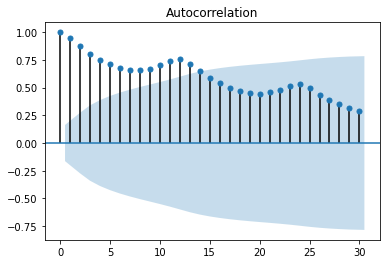

In [3]:
#  自己相関のグラフ
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(df["Passengers"], lags=30)

<Figure size 864x576 with 0 Axes>

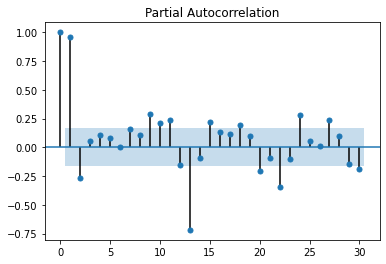

In [4]:
# 偏自己相関を可視化する
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.tsa.plot_pacf(df["Passengers"], lags=30)

## 過去12ヶ月の履歴を作成

In [5]:
for i in range(1, 13):
    df['shift%s'%i] = df['Passengers'].shift(i)

pd.concat([df.head(13), df.tail(3)], axis=0, sort=False)

,Passengers,shift1,shift2,shift3,shift4,shift5,shift6,shift7,shift8,shift9,shift10,shift11,shift12
Month,,,,,,,,,,,,,
1949-01-01,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-02-01,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-03-01,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-04-01,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-05-01,121.0,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-06-01,135.0,121.0,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-07-01,148.0,135.0,121.0,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN
1949-08-01,148.0,148.0,135.0,121.0,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN
1949-09-01,136.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN


## 1回差分の作成

In [6]:
df['deriv1'] = df['shift1'].diff(1)
df[['Passengers', 'deriv1']].head()

,Passengers,deriv1
Month,,
1949-01-01,112.0,NaN
1949-02-01,118.0,NaN
1949-03-01,132.0,6.0
1949-04-01,129.0,14.0
1949-05-01,121.0,-3.0


## 2回差分の作成

In [7]:
df['deriv2'] = df['shift1'].diff(1).diff(1)
df[['Passengers', 'deriv2']].head()

,Passengers,deriv2
Month,,
1949-01-01,112.0,NaN
1949-02-01,118.0,NaN
1949-03-01,132.0,NaN
1949-04-01,129.0,8.0
1949-05-01,121.0,-17.0


## 基礎統計量の作成

In [8]:
df['mean'] = df['shift1'].rolling(12).mean()
df['median'] = df['shift1'].rolling(12).median()
df['max'] = df['shift1'].rolling(12).max()
df['min'] = df['shift1'].rolling(12).min()
df[['Passengers', 'mean', 'median', 'max', 'min']][12:24]

,Passengers,mean,median,max,min
Month,,,,,
1950-01-01,115.0,126.666667,125.0,148.0,104.0
1950-02-01,126.0,126.916667,125.0,148.0,104.0
1950-03-01,141.0,127.583333,127.5,148.0,104.0
1950-04-01,135.0,128.333333,127.5,148.0,104.0
1950-05-01,125.0,128.833333,130.5,148.0,104.0
1950-06-01,149.0,129.166667,130.5,148.0,104.0
1950-07-01,170.0,130.333333,130.5,149.0,104.0
1950-08-01,170.0,132.166667,130.5,170.0,104.0
1950-09-01,158.0,134.000000,130.5,170.0,104.0


## 欠損値データの削除

In [9]:
df = df.dropna()
df.head()

,Passengers,shift1,shift2,shift3,shift4,shift5,shift6,shift7,shift8,shift9,shift10,shift11,shift12,deriv1,deriv2,mean,median,max,min
Month,,,,,,,,,,,,,,,,,,,
1950-01-01,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0,112.0,14.0,29.0,126.666667,125.0,148.0,104.0
1950-02-01,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0,-3.0,-17.0,126.916667,125.0,148.0,104.0
1950-03-01,141.0,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0,11.0,14.0,127.583333,127.5,148.0,104.0
1950-04-01,135.0,141.0,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,15.0,4.0,128.333333,127.5,148.0,104.0
1950-05-01,125.0,135.0,141.0,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,-6.0,-21.0,128.833333,130.5,148.0,104.0


## モデルの学習

In [10]:
x = df.drop('Passengers', axis=1)
y = df['Passengers']

# 学習データと評価データを作成
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

#データを標準化
sc = StandardScaler()
sc.fit(x_train) #学習用データで標準化
x_train_std = sc.transform(x_train)
x_test_std = sc.transform(x_test)

In [11]:
# モデルの学習
GBDT = GradientBoostingRegressor()
GBDT.fit(x_train_std, y_train)

# 予測　
y_pred = GBDT.predict(x_test_std)

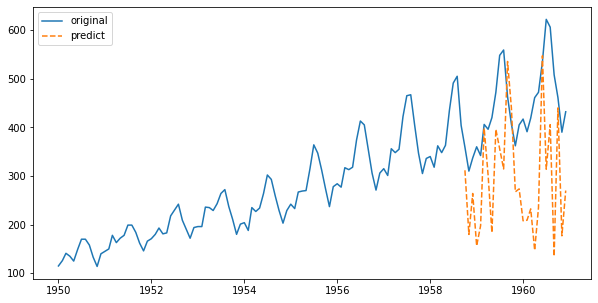

In [12]:
y_ = np.concatenate([np.array([None for i in range(len(y_train))]), y_pred])
y_ = pd.DataFrame(y_, index=df.index)

plt.figure(figsize=(10,5))
plt.plot(y, label='original')
plt.plot(y_, '--', label='predict')
plt.legend()